### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

### **Q1:**

#### **1. Gaussian Processes (GPs) and Stochastic Processes**

- **Stochastic Processes**:  
  A *stochastic process* is a collection of random variables indexed by time or space. It describes how a system evolves randomly over some domain (e.g., time series, spatial data). Formally, it's written as:
  $$
  \{X_t : t \in T\}
  $$
  where \( T \) is an index set (like time), and each \( X_t \) is a random variable.

- **Gaussian Processes (GPs)**:  
  A *Gaussian Process* is a specific type of stochastic process where **any finite collection of random variables has a joint multivariate Gaussian distribution**. A GP is completely specified by a **mean function** \( m(x) \) and a **covariance function** (kernel) \( k(x, x') \):
  \[
  f(x) \sim \mathcal{GP}(m(x), k(x, x'))
  \]
  GPs are widely used in machine learning for regression and classification tasks because they offer a principled, non-parametric Bayesian approach to modeling uncertainty.


#### **2. Variational Inference using the Evidence Lower Bound (ELBO)**

- **Variational Inference (VI)**:  
  Variational inference is a technique for approximating complex posterior distributions in Bayesian inference. Instead of sampling (like MCMC), VI posits a simpler family of distributions \( q(z) \) and finds the member of that family that is closest to the true posterior \( p(z \mid x) \), typically by minimizing the Kullback–Leibler (KL) divergence.

- **Evidence Lower Bound (ELBO)**:  
  The ELBO is the objective function that VI maximizes. It provides a lower bound on the log marginal likelihood (evidence) \( \log p(x) \), and is given by:
  $$
  \text{ELBO}(q) = \mathbb{E}_{q(z)}[\log p(x, z)] - \mathbb{E}_{q(z)}[\log q(z)]
  $$
  or equivalently:
  $$
  \text{ELBO}(q) = \log p(x) - \text{KL}(q(z) \| p(z \mid x))
  $$
  Maximizing the ELBO means making \( q(z) \) a good approximation of the true posterior \( p(z \mid x) \).


### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

Demonstrates how to use Gaussian Processes (GPs) to model earthquake data, repurposing PyMC's GP functionality for a seismology context.

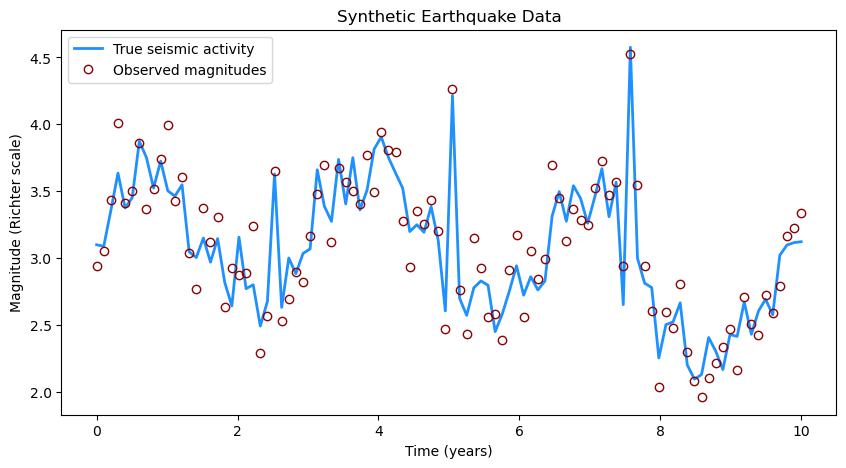

In [6]:
##generating dataset
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Generate synthetic earthquake data
n_quakes = 100
time = np.linspace(0, 10, n_quakes)

# True magnitude function with seismic cycles
true_magnitude = (3.0 + 0.5 * np.sin(time * 2) + 
                  0.3 * np.sin(time * 0.5) + 
                  0.2 * np.random.normal(size=n_quakes))

# Add some large seismic events
large_quakes = [25, 50, 75]
true_magnitude[large_quakes] += 1.5 + 0.5 * np.random.randn(len(large_quakes))

# Add observation noise
observed_magnitude = true_magnitude + 0.2 * np.random.randn(n_quakes)

# Plot the data
plt.figure(figsize=(10, 5))
plt.plot(time, true_magnitude, 'dodgerblue', lw=2, label="True seismic activity")
plt.plot(time, observed_magnitude, 'o', mfc='none', mec='darkred', label="Observed magnitudes")
plt.xlabel("Time (years)")
plt.ylabel("Magnitude (Richter scale)")
plt.title("Synthetic Earthquake Data")
plt.legend()
plt.show()

In [7]:
#build the GP model
with pm.Model() as gp_model:
    # Lengthscale prior - how quickly magnitudes change over time
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    
    # Amplitude prior - magnitude of variations
    η = pm.HalfNormal("η", sigma=2)
    
    # Noise term
    σ = pm.HalfNormal("σ", sigma=0.5)
    
    # Covariance function (Matern 3/2 for smooth but potentially abrupt changes)
    cov = η**2 * pm.gp.cov.Matern32(1, ℓ)
    
    # Instantiate GP
    gp = pm.gp.Marginal(cov_func=cov)
    
    # Likelihood
    magnitude_obs = gp.marginal_likelihood(
        "magnitude_obs", 
        X=time.reshape(-1, 1), 
        y=observed_magnitude, 
        noise=σ
    )
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, chains=2, random_seed=SEED)

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [ℓ, η, σ]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 104 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


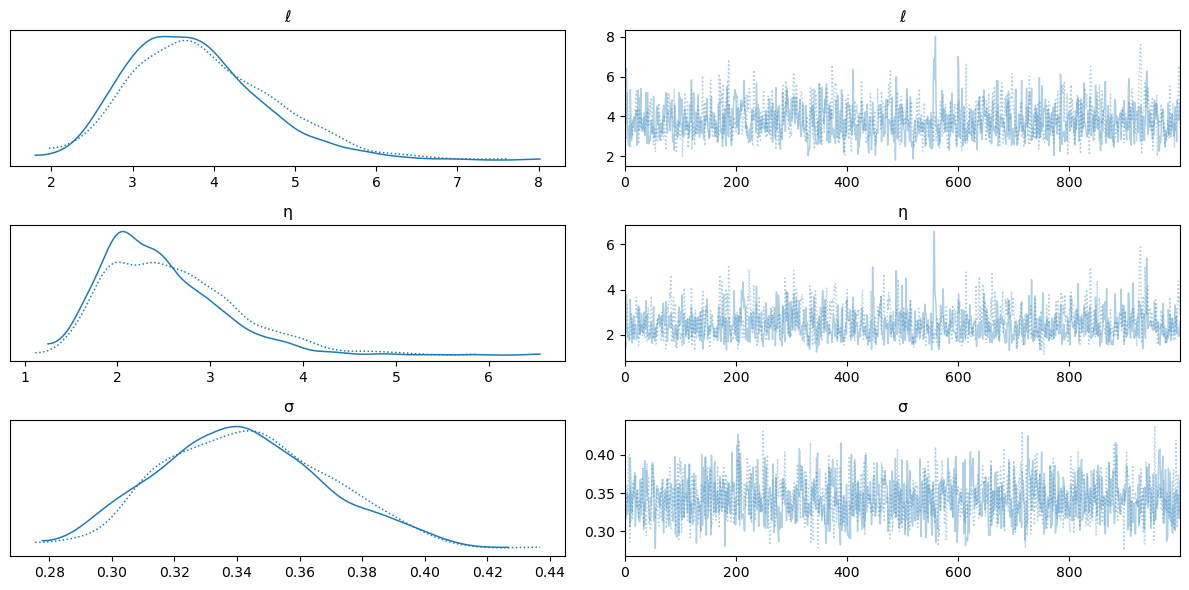

Sampling: [f_pred]


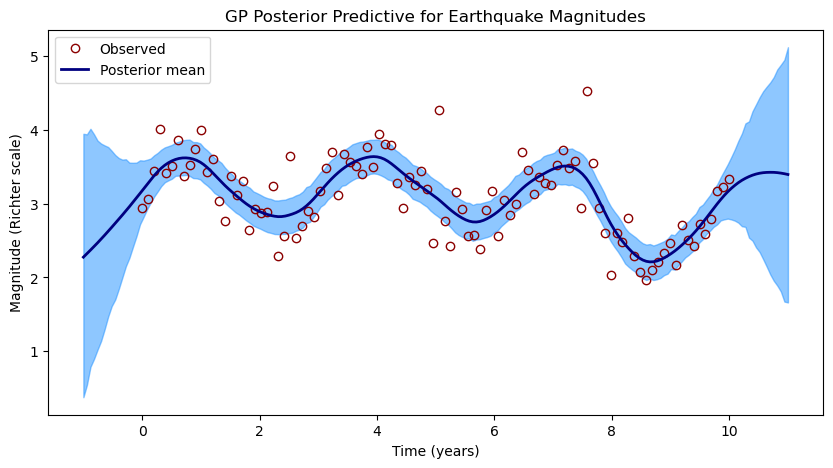

In [8]:
# Check convergence
az.plot_trace(trace, var_names=["ℓ", "η", "σ"])
plt.tight_layout()
plt.show()

# Posterior predictive checks
with gp_model:
    # Predict on a finer time grid
    t_new = np.linspace(-1, 11, 200)
    f_pred = gp.conditional("f_pred", Xnew=t_new.reshape(-1, 1))
    pp_samples = pm.sample_posterior_predictive(trace, var_names=["f_pred"])

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(time, observed_magnitude, 'o', mfc='none', mec='darkred', label="Observed")

# Plot posterior mean and 94% CI
az.plot_hdi(t_new, pp_samples.posterior_predictive["f_pred"], hdi_prob=0.94, color='dodgerblue', smooth=False)
plt.plot(t_new, pp_samples.posterior_predictive["f_pred"].mean(axis=(0, 1)), 
         color='navy', lw=2, label="Posterior mean")

plt.xlabel("Time (years)")
plt.ylabel("Magnitude (Richter scale)")
plt.title("GP Posterior Predictive for Earthquake Magnitudes")
plt.legend()
plt.show()

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.

In [16]:
import numpy as np
import pymc as pm
import pytensor.tensor as pt
import matplotlib.pyplot as plt

# Generate synthetic earthquake data (same as before)
np.random.seed(42)
n_events = 500
time_since_last = np.random.exponential(scale=30, size=n_events)
distance_to_fault = np.abs(np.random.normal(loc=10, scale=5, size=n_events))
depth = np.random.uniform(0.1, 50, size=n_events)

true_magnitude = (
    2.0 + 0.1 * np.log(time_since_last + 1) - 0.05 * distance_to_fault + 
    0.02 * depth + 0.001 * depth**2 + 0.3 * np.sin(0.1 * time_since_last) + 
    np.random.normal(0, 0.2, size=n_events)
)

large_quakes = np.random.choice(n_events, size=15, replace=False)
true_magnitude[large_quakes] += np.random.uniform(1.0, 2.0, size=15)

X = np.column_stack([time_since_last, distance_to_fault, depth])
X = (X - X.mean(axis=0)) / X.std(axis=0)
y = true_magnitude

In [18]:
def construct_nn(X, y):
    n_hidden = 5
    n_features = X.shape[1]
    
    with pm.Model() as neural_network:
        # Define data as mutable SharedVariable
        x_data = pm.MutableData('X_data', X)
        
        # Variational parameters
        w_in = pm.Normal('w_in', mu=0, sigma=1, 
                        shape=(n_features, n_hidden), 
                        initval=np.random.randn(n_features, n_hidden))
        b_in = pm.Normal('b_in', mu=0, sigma=1, 
                        shape=(n_hidden,), 
                        initval=np.random.randn(n_hidden))
        
        w_out = pm.Normal('w_out', mu=0, sigma=1, 
                         shape=(n_hidden,), 
                         initval=np.random.randn(n_hidden))
        b_out = pm.Normal('b_out', mu=0, sigma=1, 
                         shape=(1,), 
                         initval=np.random.randn(1))
        
        # Neural network operations
        act = pt.tanh(pt.dot(x_data, w_in) + b_in)
        mu = pm.Deterministic('mu', pt.dot(act, w_out) + b_out)
        
        # Observation noise
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        # Likelihood
        y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
        
        # Variational inference
        approx = pm.fit(
            n=30000,
            method='advi',
            random_seed=42,
            obj_optimizer=pm.adam(learning_rate=0.01)
        )
        
    return neural_network, approx

nn_model, approx = construct_nn(X, y)

Finished [100%]: Average Loss = 307.5


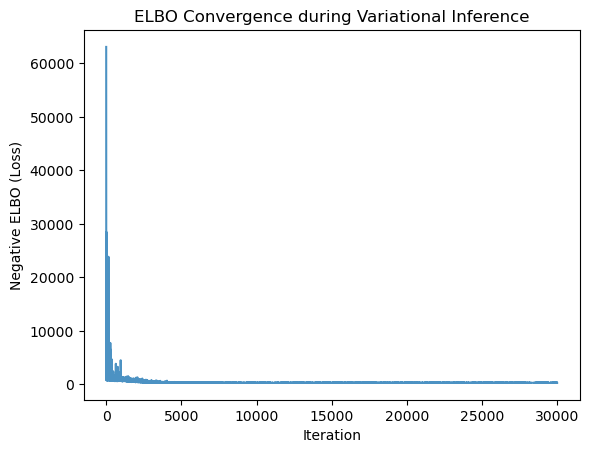

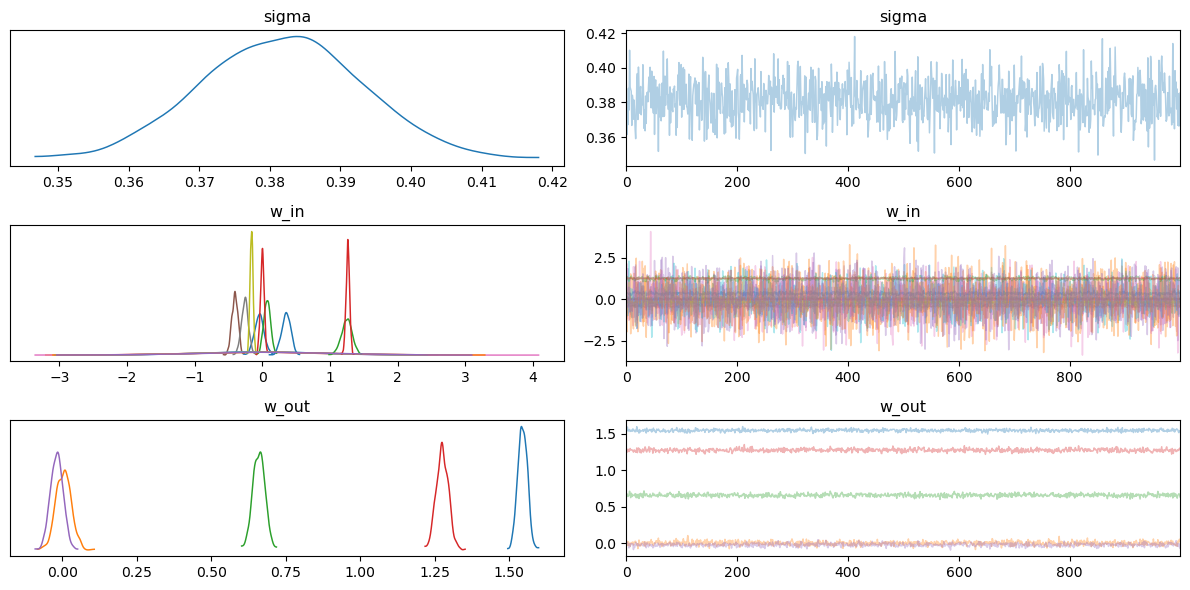

In [19]:
#analyze
# Plot ELBO convergence
plt.plot(approx.hist, alpha=0.8)
plt.xlabel('Iteration')
plt.ylabel('Negative ELBO (Loss)')
plt.title('ELBO Convergence during Variational Inference')
plt.show()

# Sample from the variational posterior
with nn_model:
    trace = approx.sample(1000)

# Plot posterior distributions
pm.plot_trace(trace, var_names=['sigma', 'w_in', 'w_out'], compact=True)
plt.tight_layout()
plt.show()